In [1]:
import os
import pandas as pd
import numpy as np
!pip install pycountry_convert
import pycountry_convert as pc
!pip install plotly
!pip install nbformat
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import durbin_watson


In [2]:
# Opening the file and cleaning and cleaning the data frame.
life_exp = pd.read_csv(os.path.join(os.getcwd(), "Life Expectancy Data.csv"),
                       encoding="utf8")
life_exp.columns = life_exp.columns.str.strip()
life_exp.rename(columns={'Life expectancy' : 'Life Expectancy'}, inplace=True)
# Pycountry (which will be used to obtain the continents of each country) has slightly different names for each country.
# As a result, they have been renamed in the for loop below. 
life_exp["Continent"] = ""
for index in range(0, len(life_exp)):
  if life_exp.loc[index, "Country"] == 'Bolivia (Plurinational State of)':
    life_exp.loc[index, "Country"] = 'Bolivia, Plurinational State of'
  elif life_exp.loc[index, "Country"] == 'Iran (Islamic Republic of)':
    life_exp.loc[index, "Country"] = 'Iran, Islamic Republic of'
  elif life_exp.loc[index, "Country"] == 'Micronesia (Federated States of)':
    life_exp.loc[index, "Country"] = 'Micronesia, Federated States of'
  elif life_exp.loc[index, "Country"] == 'Republic of Korea':
    life_exp.loc[index, "Country"] = 'Korea, Republic of'
  elif life_exp.loc[index, "Country"] == 'The former Yugoslav republic of Macedonia':
    life_exp.loc[index, "Country"] = 'North Macedonia'
  elif life_exp.loc[index, "Country"] == "Timor-Leste":
    continent_name = pc.country_alpha2_to_continent_code("TP")
    life_exp.loc[index, "Continent"] = continent_name
    continue
  elif life_exp.loc[index, "Country"] == 'Venezuela (Bolivarian Republic of)':
    life_exp.loc[index, "Country"] = 'Venezuela, Bolivarian Republic of'
  # The following lines of code are from https://stackoverflow.com/questions/55910004/get-continent-name-from-country-using-pycountry
  # The code will will mark the continent each country resides in.
  country_code = pc.country_name_to_country_alpha2(life_exp.loc[index,"Country"], cn_name_format = "default")
  continent_name = pc.country_alpha2_to_continent_code(country_code)
  life_exp.loc[index, "Continent"] = continent_name

# Before going any further, let's look at our data frame.
## Let's also take a look at an explanation of each column, based on the descriptions from the data's [source](https://www.kaggle.com/kumarajarshi/life-expectancy-who?ref=hackernoon.com)
    Status-"Developed or Developing status"
    Life Expectancy-"Life Expectancy in age"
    Adult Mortality-"Adult Mortality Rates of both sexes (probability of dying between 15 and 60 years per 1000 population)"
    Infant Deaths-"Number of Infant Deaths per 1000 population"
    Alcohol-"Alcohol, recorded per capita (15+) consumption (in litres of pure alcohol)"
    Percentage Expenditure-"Expenditure on health as a percentage of Gross Domestic Product per capita(%)"
    Hepatitis B-"Hepatitis B (HepB) immunization coverage among 1-year-olds (%)"
    Measles-"Measles - number of reported cases per 1000 population"
    BMI-"Average Body Mass Index of entire population"
    Under Five Deaths-"Number of under-five deaths per 1000 population"
    Polio-"Polio (Pol3) immunization coverage among 1-year-olds (%)"
    Total Expenditure-"General government expenditure on health as a percentage of total government expenditure (%)"
    Diphtheria-"Diphtheria tetanus toxoid and pertussis (DTP3) immunization coverage among 1-year-olds (%)"
    HIV/AIDS-"Deaths per 1 000 live births HIV/AIDS (0-4 years)"
    GDP-"Gross Domestic Product per capita (in USD)"
    Population-"Population of the country"
    Thinness 1-19 Years-"Prevalence of thinness among children and adolescents for Age 10 to 19 (%)"
    Thinness 5-9 Years-"Prevalence of thinness among children for Age 5 to 9(%)"
    Income Composition of Resources-"Human Development Index in terms of income composition of resources (index ranging from 0 to 1)"
    Schooling-"Number of years of Schooling(years)"

In [3]:
pd.set_option('display.max_columns', None)
life_exp["Country"]

0       Afghanistan
1       Afghanistan
2       Afghanistan
3       Afghanistan
4       Afghanistan
           ...     
2933       Zimbabwe
2934       Zimbabwe
2935       Zimbabwe
2936       Zimbabwe
2937       Zimbabwe
Name: Country, Length: 2938, dtype: object

In [4]:
# A temporary data frame, will be created to obtain the yearly average
# life expectancy for all the continents combined.
all_continents = life_exp.groupby("Year").mean().reset_index()
all_continents["Continent"] = "All Continents"
# The for loop below will find the yearly average life expectancy
# for each continent and then merge it with the all_continents data frame.
for continent in list(life_exp["Continent"].unique()):
  continent_df = life_exp[life_exp["Continent"] == continent]
  continent_df = continent_df.groupby("Year").mean().reset_index()
  continent_df["Continent"] = str(continent)
  all_continents = pd.merge(all_continents, continent_df, how="outer")
# At this point, the all_continents data frame has the annual average
# life expectancy for each continent as well as the annual average
# life expectancy for all the continents combined.
life_exp_fig = px.line(all_continents, x="Year", y="Life Expectancy",
                       color="Continent",
                       title='Life Expectency Across Continents')
life_exp_fig.show()


In [5]:
# The function below will take a metric (e.g. GDP)
# and compare it across continents.
def BarGraph(metric):
  temp_dict = {}
  # The for loop below creates a dictionary where the keys are
  # the continients and the values are the mean metric of each continent.
  # If the metric passed is GDP, then the values
  # are the mean GDP for each continent.
  for cont in life_exp["Continent"].unique():
    temp_dict[cont] = life_exp[life_exp["Continent"] == cont][metric].mean()
  # Create a dataframe from the dictionary and formatting it.
  df = pd.DataFrame(temp_dict, index=[metric])
  df = df.transpose().reset_index()
  df = df.rename(columns={"index": "Continent"})
  df = df.sort_values(by=[metric])
  fig = px.bar(df, x="Continent", y=metric,
               color=metric,
               title="Average "+metric+' Across Continents')
  fig.show()


BarGraph("Life Expectancy")
BarGraph("GDP")
BarGraph("Adult Mortality")
BarGraph("Income composition of resources")
BarGraph("Schooling")

In [6]:
fig = px.pie(life_exp,
             values="Population",
             names="Continent",
             title="Population Share of Each Continent")
fig.show()

# Before going any further, it will be useful to clean the data.

In [7]:
# The code for filling in nan values is based off of the following source:
# https://www.youtube.com/watch?v=J_LnPL3Qg70sy

# Removing the dependent variables
independent = life_exp.drop(["Life Expectancy", "Country"], axis=1)
values = {}
for col in independent:  # Filling the NaN values
  if independent[col].isnull().values.any():
    values[col] = independent[col].mean()
independent.fillna(value=values, inplace=True)

life_exp["Life Expectancy"].fillna(value=life_exp["Life Expectancy"].mean(),
                                   inplace=True)

# The following for loops will convert the columns "Continent" and "Status"
# to numerical values using one hot encoding.
for cont in independent["Continent"].unique():
  new_col = "Continent_"+cont
  independent[new_col] = 0

  # Filtering the data frame by each continent,
  # then setting the the continent's column to 1.
  # E.g. If the data frame is filtered so that only countries in
  # Africa are present, it sets the column "Continent_AF" to 1.
  independent.loc[independent['Continent'] == cont, new_col] = 1

for status in independent["Status"].unique():
  new_status = "Status_"+status
  independent[new_status] = 0
  independent.loc[independent['Status'] == status, new_status] = 1

independent = independent.drop("Continent", axis=1)
independent = independent.drop("Status", axis=1)

# The Assumptions of Multiple Linear Regression Using Ordinary Least Squares (OLS) Regression
## To ensure that our model is the Best Linear Unbiased Estimator, we need to handle some key assumptions. If an assumption is violated, we need to handle them as best as we can to increase confidence in our predictions. 
## The following are the assumptions we will be dealing with:<br>1. Linearity <br>2. No Multicollinearity <br>3. Homoscedasticity <br>4. No Autocorrelation <br>5. Mean Residual of Zero 

# Dealing with Multicollinearity:
### There may be variables that are strongly correlated with each other. If two variables are highly correlated, we should remove one to avoid the issues that accompany multicollinearity.

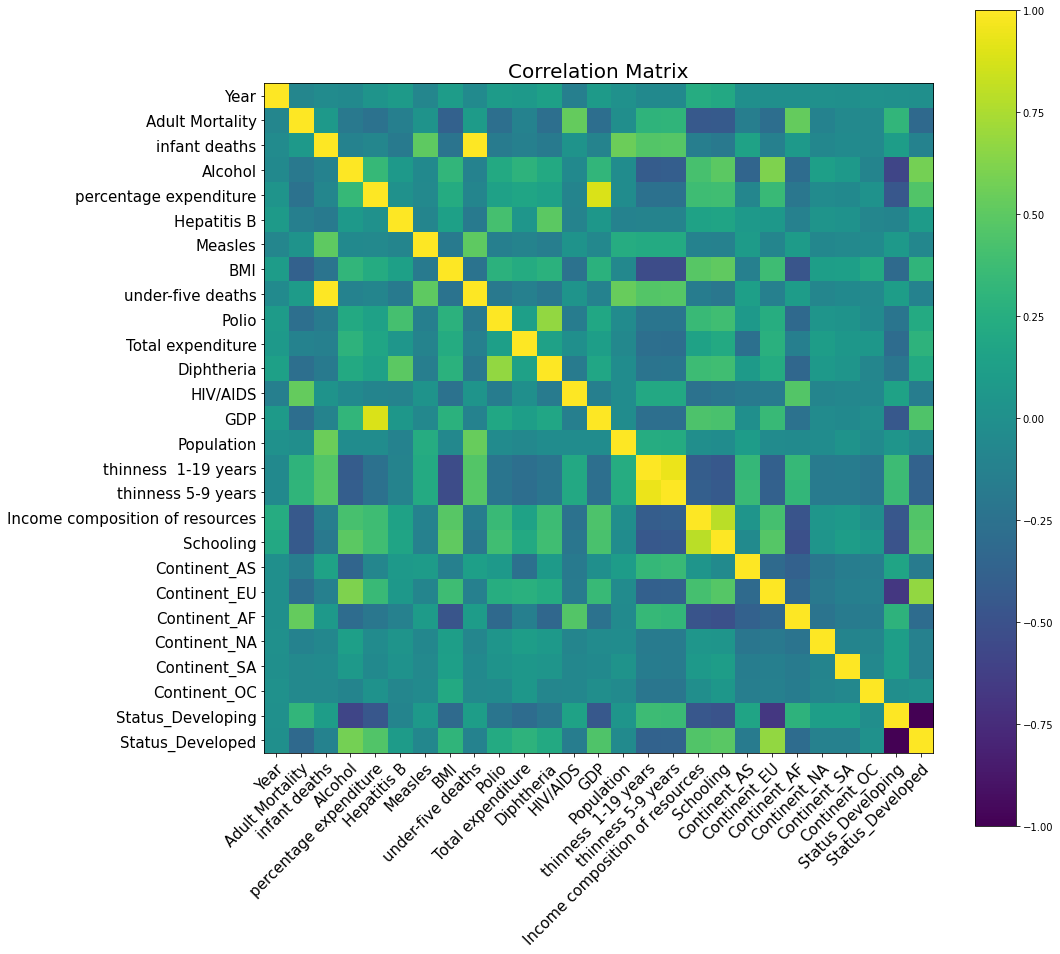

In [8]:
def CorrelationMatrix(df):
  # The code used to create this correlation matrix is from
  # https://towardsdatascience.com/introduction-to-data-visualization-in-python-89a54c97fbed
  # Creates a correlation matrix
  corr = df.corr()
  fig, ax = plt.subplots(figsize=(15, 15))
  # create heatmap
  im = ax.imshow(corr.values)
  plt.colorbar(im)
  # set labels
  ax.set_xticks(np.arange(len(corr.columns)))
  ax.set_yticks(np.arange(len(corr.columns)))
  ax.set_xticklabels(corr.columns, fontsize=15)
  ax.set_yticklabels(corr.columns, fontsize=15)
  ax.set_title("Correlation Matrix", fontsize=20)
  # Rotate the tick labels and set their alignment.
  plt.setp(ax.get_xticklabels(),
           rotation=45, ha="right",
           rotation_mode="anchor")
  plt.show()


CorrelationMatrix(independent)

# Systematically Rooting Out Multicollinearity
### We can use the variance inflation factor with the Statsmoels library to figure out which variables have high multicollinearity. The following is an excerpt from the its [documentation](statsmodels.org/stable/generated/statsmodels.stats.outliers_influence.variance_inflation_factor.html) on the variance inflation factor: 
    The variance inflation factor is a measure for the increase of the variance of the parameter estimates if an additional variable, given by exog_idx is added to the linear regression. It is a measure for multicollinearity of the design matrix, exog.
    One recommendation is that if VIF is greater than 5, then the explanatory variable given by exog_idx is highly collinear with the other explanatory variables, and the parameter estimates will have large standard errors because of this.

In [9]:
# The code used to implement the variance inflation factor is from
# https://github.com/areed1192/sigma_coding_youtube
X1 = sm.tools.add_constant(independent)
X1 = X1.astype('float64')
series_before = pd.Series([variance_inflation_factor(X1.values, i) for i in range(X1.shape[1])],
                          index=X1.columns)
"""
# The line above runs variance_inflation_factor through
# each cell of each row of X1.
# X1.values is a matrix of all the cells (explanatory variables) in each row.
# i simply tells the program which row we are at.
"""
# Displays the variance inflation factor for each variable.
# Variables with a factor above 5 should be dropped.
display(series_before)


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning:

divide by zero encountered in double_scalars

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning:

divide by zero encountered in double_scalars



const                                0.000000
Year                                 1.190280
Adult Mortality                      1.821399
infant deaths                      187.136375
Alcohol                              2.393750
percentage expenditure               5.179708
Hepatitis B                          1.413507
Measles                              1.396425
BMI                                  1.892693
under-five deaths                  185.827147
Polio                                1.957254
Total expenditure                    1.244642
Diphtheria                           2.244789
HIV/AIDS                             1.586519
GDP                                  5.382088
Population                           1.487732
thinness  1-19 years                 8.856092
thinness 5-9 years                   9.089825
Income composition of resources      3.181293
Schooling                            3.500008
Continent_AS                              inf
Continent_EU                      

### As we can see, several variables have a variance influence factor above 5. However, we shouldn't eliminate them all at once. Instead, we will eliminate them one at a time until every variable has a factor below 5, preserving as many variables as possible.

In [10]:
new_independent = independent
series_after = series_before

# While there are variables with a variance influence factor above 5
while series_after.sort_values(ascending=False)[1] > 5:

  # Sorting the series by descending values guarantees that
  # the first item in the list will have a variance influence factor above 5
  names = list(series_after.sort_values(ascending=False).index)

  # Drops the variable with an influence factor above 5.
  new_independent = new_independent.drop(names[1], axis=1)

  # The following two lines of code are from
  # https://github.com/areed1192/sigma_coding_youtube/tree/master/python
  # Creates a new constant as we just removed a variable.
  X2 = sm.tools.add_constant(new_independent)
  X2 = X2.astype("float64")
  series_after = pd.Series([variance_inflation_factor(X2.values, i) for i in range(X2.shape[1])],
                            index=X2.columns)
display(series_after)


const                              217778.825715
Year                                    1.157706
Adult Mortality                         1.801115
Alcohol                                 2.281338
percentage expenditure                  1.348436
Hepatitis B                             1.405297
Measles                                 1.383958
BMI                                     1.812980
under-five deaths                       2.173625
Polio                                   1.948471
Total expenditure                       1.222136
Diphtheria                              2.213643
HIV/AIDS                                1.515188
Population                              1.439626
thinness  1-19 years                    2.199922
Income composition of resources         3.146670
Schooling                               3.412475
Continent_AS                            1.796451
Continent_EU                            3.042446
Continent_NA                            1.498547
Continent_OC        

## Let's take a look at our new data frame.

In [11]:
new_independent

,Year,Adult Mortality,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,Population,thinness 1-19 years,Income composition of resources,Schooling,Continent_AS,Continent_EU,Continent_NA,Continent_OC,Status_Developed
0,2015,263.0,0.01,71.279624,65.0,1154,19.1,83,6.0,8.16,65.0,0.1,33736494.0,17.2,0.479,10.1,1,0,0,0,0
1,2014,271.0,0.01,73.523582,62.0,492,18.6,86,58.0,8.18,62.0,0.1,327582.0,17.5,0.476,10.0,1,0,0,0,0
2,2013,268.0,0.01,73.219243,64.0,430,18.1,89,62.0,8.13,64.0,0.1,31731688.0,17.7,0.470,9.9,1,0,0,0,0
3,2012,272.0,0.01,78.184215,67.0,2787,17.6,93,67.0,8.52,67.0,0.1,3696958.0,17.9,0.463,9.8,1,0,0,0,0
4,2011,275.0,0.01,7.097109,68.0,3013,17.2,97,68.0,7.87,68.0,0.1,2978599.0,18.2,0.454,9.5,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2933,2004,723.0,4.36,0.000000,68.0,31,27.1,42,67.0,7.13,65.0,33.6,12777511.0,9.4,0.407,9.2,0,0,0,0,0
2934,2003,715.0,4.06,0.000000,7.0,998,26.7,41,7.0,6.52,68.0,36.7,12633897.0,9.8,0.418,9.5,0,0,0,0,0
2935,2002,73.0,4.43,0.000000,73.0,304,26.3,40,73.0,6.53,71.0,39.8,125525.0,1.2,0.427,10.0,0,0,0,0,0
2936,2001,686.0,1.72,0.000000,76.0,529,25.9,39,76.0,6.16,75.0,42.1,12366165.0,1.6,0.427,9.8,0,0,0,0,0


## The new correlation matrix has far fewer green-yellow squares (green-yellow squares indicate a high correlation between variables). 

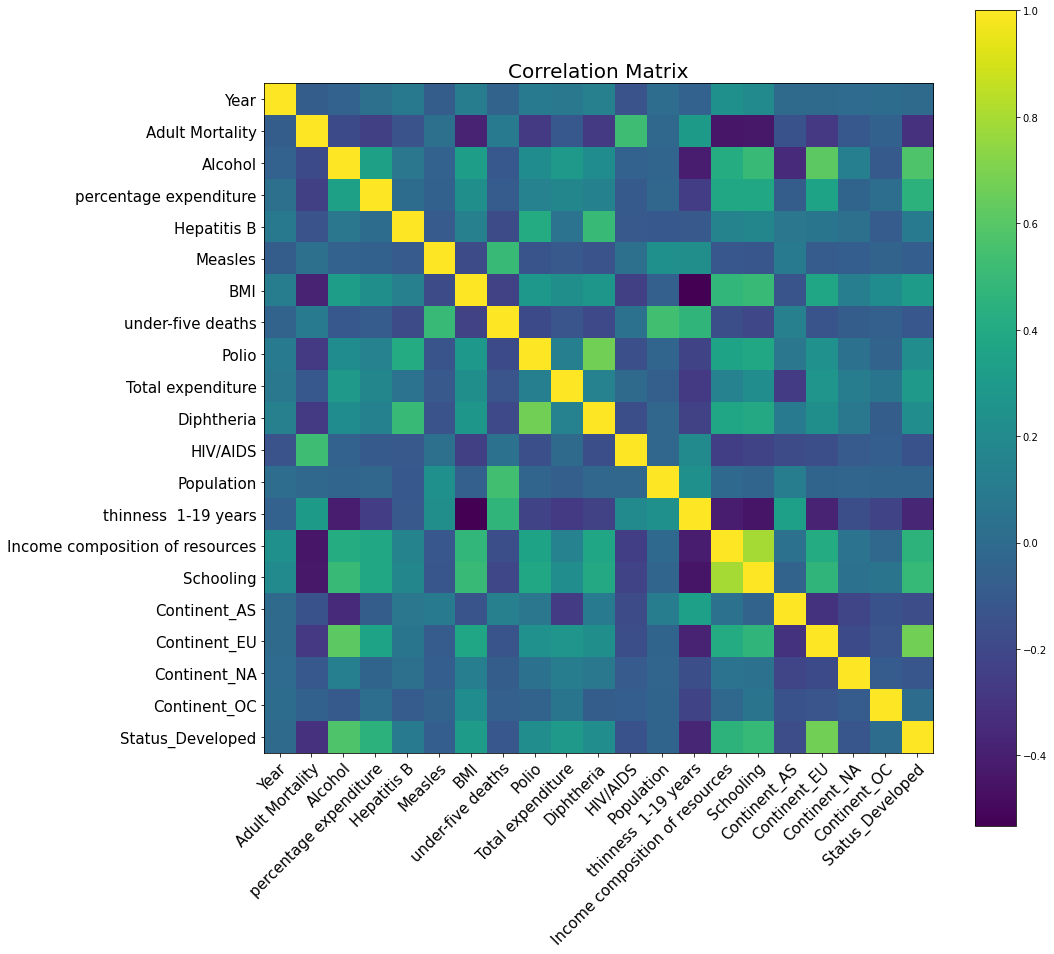

In [12]:
CorrelationMatrix(new_independent)

# Testing for Heteroscedasticity

## The first method we will use is the Goldfeld–Quandt test. While there is a function that can perform the test, we will review the steps necessary to perform the test to understand what is going on. The steps are based on the function's [source code](https://www.statsmodels.org/stable/_modules/statsmodels/stats/diagnostic.html#het_goldfeldquandt).
    Divide the dataset into two sections. For each section, do the following: 
1. Fit a regression model to the data.
2. Use the regression model to predict the y values.
3. Find the mean squared error. To compute this, find the difference between the predicted value of y and the actual value of y, then square it. Do this for all the predicted/actual values of y, and then add them all up. This will be the sum of squared errors. Divide the sum by the sample size to find the mean squared error (MSE).
4. Compare the MSE for both sections by dividing them. This will become the ratio of mean squared residual errors.
5. Compute the residual degree of freedom (DF). This is calculated with the following formula: DF=N-K-1 where N is the number of samples and K is the number of parameters.
6. Use the ratio of mean squared residual errors along with the residual degree of freedom to calculate our p-value. If p<.05, then we can reject our null hypothesis (that the variance is about the same throughout). In other words, if p<.05, then heteroscedasticity is likely to present.


In [13]:
gq_test = sm.stats.diagnostic.het_goldfeldquandt(life_exp["Life Expectancy"].astype('float64'),
                                                 new_independent.astype('float64'))
if gq_test[1] > .05:
  print("Heteroscedasticity is likely not present. p > .05")
else:
  print("Heteroscedasticity is likely present. p <= .05")
print(gq_test[1])

Heteroscedasticity is likely not present. p > .05
0.08925368603565402


## Another method to check for heteroscedasticity is the Breusch-Pagan-Godfrey test. <br><br> The steps are based on the function's [source code](https://www.statsmodels.org/stable/_modules/statsmodels/stats/diagnostic.html#het_breuschpagan).
1. Create a linear regression model with the dataset and fit a line to it.
2. Capture the residuals of this model into a list or array. 
3. Create a second linear regression model. This time, Y will not be life expectancy, but rather the residuals from the original model. In other words, we will be using the X variable to try and predict the residuals. Again, we will fit a line to this model. 
4. Using the second model, we can find the p-value. 

    Note: The function used below for the test will return two p-values. One will be the p-value derived from the f-statistic 


In [14]:
# To run this test, we need to run a regression and obtain its residuals.
# The code below takes a random sample from the data frame and runs
# a regression on it. We will run a test regression a couple of times,
# so we will create a function that does this.
def TestModel():
  X_train, X_test, y_train, y_test = train_test_split(new_independent,
                                                      life_exp["Life Expectancy"],
                                                      test_size=int(len(new_independent)*.25))
  test_model = sm.OLS(y_train, X_train.astype("float"))
  return test_model

In [15]:
bp_test = sm.stats.diagnostic.het_breuschpagan(TestModel().fit().resid,
                                               TestModel().exog,
                                               robust=True)
if bp_test[1] > .05 and bp_test[3] > .05:
  print("Heteroscedasticity is likely not present. p > .05")
else:
  print("Heteroscedasticity is likely present. p <= .05")
print("p =", bp_test[1])

Heteroscedasticity is likely present. p <= .05
p = 2.581895737490193e-88


## It seems as though heteroscedasticity might be present. 
### This means that the range of y values is not consistent. Some areas will have a larger range of y values and some will have a small range. This is an issue because we will have less information in certain areas. If there is more variance in the dependent variable as the independent variable(s) increase, then we will have less information as it becomes harder to accurately predict the dependent variable. <br><br>While heteroscedasticity does not make OLS regression biased, it does make it [less efficient](https://www.sfu.ca/~pendakur/teaching/buec333/Heteroskedasticity%20and%20Correlations%20Across%20Errors.pdf). Furthermore, heteroscedasticity means that the standard error [will be less accurate](http://www.homepages.ucl.ac.uk/~uctpsc0/Teaching/GR03/Heter&Autocorr.pdf). The standard error is based on the standard deviation as the standard error is standard deviation divided by the square root of the number of samples. Standard deviation is based on variance as it is the square root of the variance in observations. If the variance is inconsistent, then the standard error, which is derived from the variance, [may be inaccurate](https://www.ucl.ac.uk/~uctp41a/b203/lecture9.pdf). Because researchers [often use standard error in hypothesis testing](https://www.biochemia-medica.com/en/journal/18/1/10.11613/BM.2008.002#:~:text=The%20formula%2C%20(1%2DP,correlation%20measure%2C%20the%20Pearson%20R.), inaccurate standard errors will make the conclusions reached less reliable. 



# Testing for Autocorrelation
### If [autocorrelation](https://corporatefinanceinstitute.com/resources/knowledge/other/autocorrelation/) is present, then one can use one point's residual to predict the next. If there is a positive correlation, then the next point's residual will go in the same direction as the current point's. If the current point has a positive residual, then the next point will likely also have a positive residual. If the current point has a negative residual, then the next point will likely follow suit. With a negative correlation, the next point's residual will go in the opposite direction. If the current point has a positive residual, then it is likely that the next point will have a negative residual and vice versa. <br><br> [Autocorrelation](http://www.homepages.ucl.ac.uk/~uctpsc0/Teaching/GR03/Heter&Autocorr.pdf) does not make OLS regression biased. However, when it is present the variance becomes inconsistent. As aforementioned, inconsistent variance means that the standard errors become less accurate, making hypothesis testing more difficult. Furthermore, it makes the regression [less efficient.](https://www.sfu.ca/~pendakur/teaching/buec333/Heteroskedasticity%20and%20Correlations%20Across%20Errors.pdf)<br><br>We will be using the Durbin Watson statistic to test for autocorrelation. A value between 1.5 and 2.5 indicates no autocorrelation, a value above 2.5 indicates a negative autocorrelation, and a value below 1.5 indicates a positive autocorrelation.<br><br>The test divides the sum of differences squared by the sum of errors squared and [works as follows](https://www.statsmodels.org/stable/_modules/statsmodels/stats/stattools.html#durbin_watson):
1. Create and fit a linear regression model.
2. Capture the residuals of the model.
3. Pass the residuals to the Stats Models function durbin_watson. The following steps will outline how this function works. 
4. For each item in the array of residuals, calculate the difference between the current and next item.
5. Add up all the differences from step 4 and square the sum.
6. Add up all the residuals that were passed to the function in step 3 and square the sum.
7. Divide the result of step 5 by the result of step 6. Return the dividend. 


In [16]:
# Like the Breusch-Pagan-Godfrey test, the Durbin Watson test requires that
# a regression is run and that we obtain the residuals. We will re-run the
# regression with a different random sample to get new residuals.

durbin_watson_resid = durbin_watson(TestModel().fit().resid)
if durbin_watson_resid >= 1.5 and durbin_watson_resid <= 2.5:
  print("Autocorrelation is not an issue.")
elif durbin_watson_resid > 2.5:
  print("Autocorrelation is present. There is a negative serial correlation")
elif durbin_watson_resid < 1.5:
  print("Autocorrelation is present. There is a positive serial correlation")

print("The result of the test is:", durbin_watson(list(TestModel().fit().resid)))

Autocorrelation is not an issue.
The result of the test is: 2.0555935768512446


# Dealing with Heteroscedasticity
## It seems as though heteroscedasticity but not autocorrelation is present in the dataset. We will discuss two methods of handling this issue.<br><br>One way to handle this issue is to run the regression and fit the model using heteroscedasticity robust standard errors. This will ["obtain unbiased standard errors of OLS coefficients under heteroscedasticity."](https://economictheoryblog.com/2016/08/07/robust-standard-errors/)<br>Another option is to use [General Least Squares](http://www.homepages.ucl.ac.uk/~uctpsc0/Teaching/GR03/Heter&Autocorr.pdf) (GLS) regression instead, which has the potential to be more efficient than OLS regression.<br>For this project, we will be going with the former option.

## Checking the Mean Residual Error
### We will be checking if the the error the model makes, on average, is close to zero.

In [17]:
TestModel().fit().resid.mean()

5.139870138226124e-05

## As we can see, the mean error is close to zero. 

# Creating the Model and Making Predictions
## The formula below displays the coefficients for each variable. For instance, if the HIV/AIDS variable increases by 1, the life expectancy changes by the HIV/AIDS's coefficient. If the coefficient is -.048, then the life expectancy decreases by .048 for every unit of increase in HIV/AIDs.


In [18]:
# This will obtain a random sample, add a constant, and run a regression.
X_train, X_test, y_train, y_test = train_test_split(new_independent,
                                                    life_exp["Life Expectancy"],
                                                    test_size=int(len(new_independent)*.25))
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

# Fitting the model using heteroscedasticity and autocorrelation robust standard errors
model = sm.OLS(y_train, X_train.astype("float"))
results = model.fit(cov_type="HAC",cov_kwds={"maxlags":25})
intercept = results.params[0]
print ("The linear regression formula is as follows: Life Expectancy = \n", intercept)
# This line is from
# https://github.com/areed1192/sigma_coding_youtube/tree/master/python/python-data-science
for cf in zip(new_independent.columns, results.params[1:]):
  print ("+", cf[0], cf[1])

The linear regression formula is as follows: Life Expectancy = 
 -22.47058599923477
+ Year 0.038153736759437874
+ Adult Mortality -0.01712875234903838
+ Alcohol 0.007167488477439393
+ percentage expenditure 0.00023821351301526328
+ Hepatitis B -0.013893453785108843
+ Measles -2.3461768835724074e-05
+ BMI 0.04152344014557086
+ under-five deaths -0.0021209982084063475
+ Polio 0.031032772775041018
+ Total expenditure 0.0686077187959848
+ Diphtheria 0.03412324502562544
+ HIV/AIDS -0.4095566417697679
+ Population 3.970987825292253e-09
+ thinness  1-19 years -0.1268575770775396
+ Income composition of resources 5.7490890729736
+ Schooling 0.5752064179169334
+ Continent_AS 3.5799349636459388
+ Continent_EU 2.419441201767517
+ Continent_NA 4.3842469726880315
+ Continent_OC 1.2323562554768455
+ Status_Developed 2.157082992712635


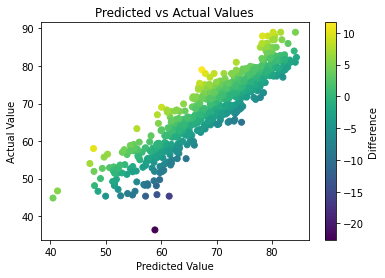

In [19]:
y_pred = results.predict(X_test)

# The scatterplot is colorcoded based on how different the actual and
# predicted life expectancies are.
sc = plt.scatter(y_pred, y_test, c=y_test - y_pred)
plt.xlabel("Predicted Value")
plt.ylabel("Actual Value")
cbar = plt.colorbar(sc)
cbar.set_label('Difference')
plt.title("Predicted vs Actual Values")
plt.show()

# Let's take a look at the results.

In [20]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:        Life Expectancy   R-squared:                       0.829
Model:                            OLS   Adj. R-squared:                  0.827
Method:                 Least Squares   F-statistic:                     604.9
Date:                Tue, 28 Jun 2022   Prob (F-statistic):               0.00
Time:                        16:27:41   Log-Likelihood:                -6150.8
No. Observations:                2204   AIC:                         1.235e+04
Df Residuals:                    2182   BIC:                         1.247e+04
Df Model:                          21                                         
Covariance Type:                  HAC                                         
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/base/model.py:1871: ValueWarning:

covariance of constraints does not have full rank. The number of constraints is 21, but rank is 20

